In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model
from sqlalchemy import create_engine
import seaborn as sns
from scipy.stats import boxcox
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
df = pd.read_sql_query('select * from houseprices',con=engine)

engine.dispose()


In [3]:
clean_df = df.copy()
clean_df.alley.unique()
clean_df.alley.fillna('None', inplace=True)
clean_df.lotfrontage.fillna(0, inplace=True)

In [4]:
print(clean_df.masvnrtype.unique())
clean_df.masvnrtype.fillna('None', inplace=True)
clean_df.masvnrarea.fillna(0.0, inplace=True)
print(clean_df.bsmtqual.unique())
clean_df.bsmtqual.fillna('NA', inplace=True)
print(clean_df.bsmtcond.unique())
clean_df.bsmtcond.fillna('NA', inplace=True)
print(clean_df.bsmtexposure.unique())
clean_df.bsmtexposure.fillna('NA', inplace=True)
print(clean_df.bsmtfintype1.unique())
clean_df.bsmtfintype1.fillna('NA', inplace=True)
print(clean_df.bsmtfintype2.unique())
clean_df.bsmtfintype2.fillna('NA', inplace=True)
print(clean_df.bsmtexposure.unique())
clean_df.bsmtexposure.fillna('NA', inplace=True)
print(clean_df.electrical.unique())
for electrical in clean_df.electrical.unique():
    print(electrical, len(clean_df[clean_df.electrical == electrical]))
clean_df.electrical.fillna('SBrkr', inplace=True)
print(clean_df.fireplacequ.unique())
clean_df.fireplacequ.fillna('NA', inplace=True)
print(clean_df.garagetype.unique())
clean_df.garagetype.fillna('NA', inplace=True)
clean_df.garageyrblt.fillna('NA', inplace=True)
clean_df.garagefinish.fillna('NA', inplace=True)
clean_df.garagequal.fillna('NA', inplace=True)
clean_df.garagecond.fillna('NA', inplace=True)
print(clean_df.poolqc.unique())
clean_df.poolqc.fillna('NA', inplace=True)
print(clean_df.fence.unique())
clean_df.fence.fillna('NA', inplace=True)
print(clean_df.miscfeature.unique())
clean_df.miscfeature.fillna('NA', inplace=True)
clean_df.info()

['BrkFace' 'None' 'Stone' 'BrkCmn' None]
['Gd' 'TA' 'Ex' None 'Fa']
['TA' 'Gd' None 'Fa' 'Po']
['No' 'Gd' 'Mn' 'Av' None]
['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' None 'LwQ']
['Unf' 'BLQ' None 'ALQ' 'Rec' 'LwQ' 'GLQ']
['No' 'Gd' 'Mn' 'Av' 'NA']
['SBrkr' 'FuseF' 'FuseA' 'FuseP' 'Mix' None]
SBrkr 1334
FuseF 27
FuseA 94
FuseP 3
Mix 1
None 0
[None 'TA' 'Gd' 'Fa' 'Ex' 'Po']
['Attchd' 'Detchd' 'BuiltIn' 'CarPort' None 'Basment' '2Types']
[None 'Ex' 'Fa' 'Gd']
[None 'MnPrv' 'GdWo' 'GdPrv' 'MnWw']
[None 'Shed' 'Gar2' 'Othr' 'TenC']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            1460 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null ob

In [6]:
feature_df = clean_df[['lotarea', 'overallqual']].copy()
x = pd.get_dummies(clean_df.bldgtype, drop_first=True).copy()
for i in range(len(clean_df.bldgtype.unique()) - 1):
    feature_df['bldgtype' + clean_df.bldgtype.unique()[i + 1]] = x.iloc[:,i]
x = pd.get_dummies(clean_df.housestyle, drop_first=True).copy()
for i in range(len(clean_df.housestyle.unique()) - 1):
    feature_df['housestyle' + clean_df.housestyle.unique()[i + 1]] = x.iloc[:,i]
x = pd.get_dummies(clean_df.electrical, drop_first=True).copy()
for i in range(len(clean_df.electrical.unique()) - 1):
    feature_df['electrical' + clean_df.electrical.unique()[i + 1]] = x.iloc[:,i]

In [7]:
keywords = ['garagecond', 'garagequal', 'kitchenqual', 'bsmtcond', 'bsmtqual', 'extercond', 'exterqual' ]
for word in keywords:
    nums = []
    for row in clean_df[word]:
        if row == 'Fa':
            nums.append(1)
        elif row == 'TA':
            nums.append(2)
        elif row == 'Gd':
            nums.append(3)
        elif row == 'Ex':
            nums.append(4)
        else:
            nums.append(0)
    feature_df[word] = nums

In [8]:
from scipy.stats.mstats import winsorize
feature_df['logsaleprice'] = winsorize(np.log(clean_df.saleprice), (0.01, 0.02))

In [9]:
import statsmodels.api as sm

Y = feature_df['logsaleprice']
X = feature_df.iloc[:, :-1]

X = sm.add_constant(X)
results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           logsaleprice   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     217.3
Date:                Tue, 10 Sep 2019   Prob (F-statistic):               0.00
Time:                        17:58:37   Log-Likelihood:                 451.04
No. Observations:                1460   AIC:                            -852.1
Df Residuals:                    1435   BIC:                            -719.9
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               10.3396      0.044    235.743      0.000      10.254      10.426
lotarea            5.11e-06   4.92e-07     10.388      0.000    4.14e-06    6.07e-06
overallqual          0.1309      0.006     22.166      0.000       0.119       0.142
bldgtype2fmCon       0.0120      0.034      0.352      0.725      -0.055       0.079
bldgtypeDuplex       0.0877      0.027      3.263      0.001       0.035       0.140
bldgtypeTwnhsE      -0.2484      0.029     -8.629      0.000      -0.305      -0.192
bldgtypeTwnhs       -0.1394      0.019     -7.530      0.000      -0.176      -0.103
housestyle1Story    -0.1527      0.051     -3.006      0.003      -0.252      -0.053
housestyle1.5Fin     0.0216      0.016      1.313      0.189      -0.011       0.054
housestyle1.5Unf     0.1798      0.065      2.750      0.006       0.052       0.308
housestyleSFoyer    -0.0456      0.057     -0.801      0.423      -0.157       0.066
housestyleSLvl       0.0652      0.018      3.650      0.000       0.030       0.100
housestyle2.5Unf    -0.0572      0.034     -1.659      0.097      -0.125       0.010
housestyle2.5Fin     0.0376      0.027      1.392      0.164      -0.015       0.090
electricalFuseF     -0.0167      0.040     -0.421      0.674      -0.094       0.061
electricalFuseA     -0.0205      0.107     -0.192      0.848      -0.230       0.189
electricalFuseP     -0.3362      0.182     -1.842      0.066      -0.694       0.022
electricalMix        0.0627      0.020      3.111      0.002       0.023       0.102
garagecond           0.0125      0.024      0.524      0.600      -0.034       0.059
garagequal           0.0729      0.023      3.104      0.002       0.027       0.119
kitchenqual          0.0845      0.011      7.769      0.000       0.063       0.106
bsmtcond             0.0007      0.014      0.053      0.958      -0.026       0.027
bsmtqual             0.0855      0.010      8.698      0.000       0.066       0.105
extercond            0.0135      0.014      0.957      0.339      -0.014       0.041
exterqual            0.0595      0.014      4.305      0.000       0.032       0.087
==============================================================================
Omnibus:                      157.452   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              561.954
Skew:                          -0.494   Prob(JB):                    9.40e-123
Kurtosis:                       5.875   Cond. No.                     5.65e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.65e+05. This might indicate that there are
strong multicollinearity or other numerical pr

In [10]:
# Let's check the assumptions of linear regression:
# 1. Linearity of the model in its coefficients. Met by the assumptions of the model already.

In [12]:
# 2. The error term should be zero on average.
predictions = results.predict(X)
errors = Y - predictions

print("Mean of the errors in the medical costs model is: {}".format(np.mean(errors)))
# Good.

Mean of the errors in the medical costs model is: 1.5885010202198405e-13


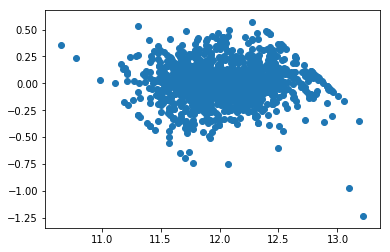

In [13]:
# 3. Homoscedasticity
plt.scatter(predictions, errors)

In [14]:
from scipy.stats import bartlett
from scipy.stats import levene

print(bartlett(predictions, errors))
print(levene(predictions, errors))
# Failed. This could mean we have weird outliers in our data,
# or that we have omitted variables that are important in explaining the variance.

BartlettResult(statistic=569.3094822089945, pvalue=7.934563140588962e-126)
LeveneResult(statistic=494.30479573867933, pvalue=2.6957732025928008e-101)


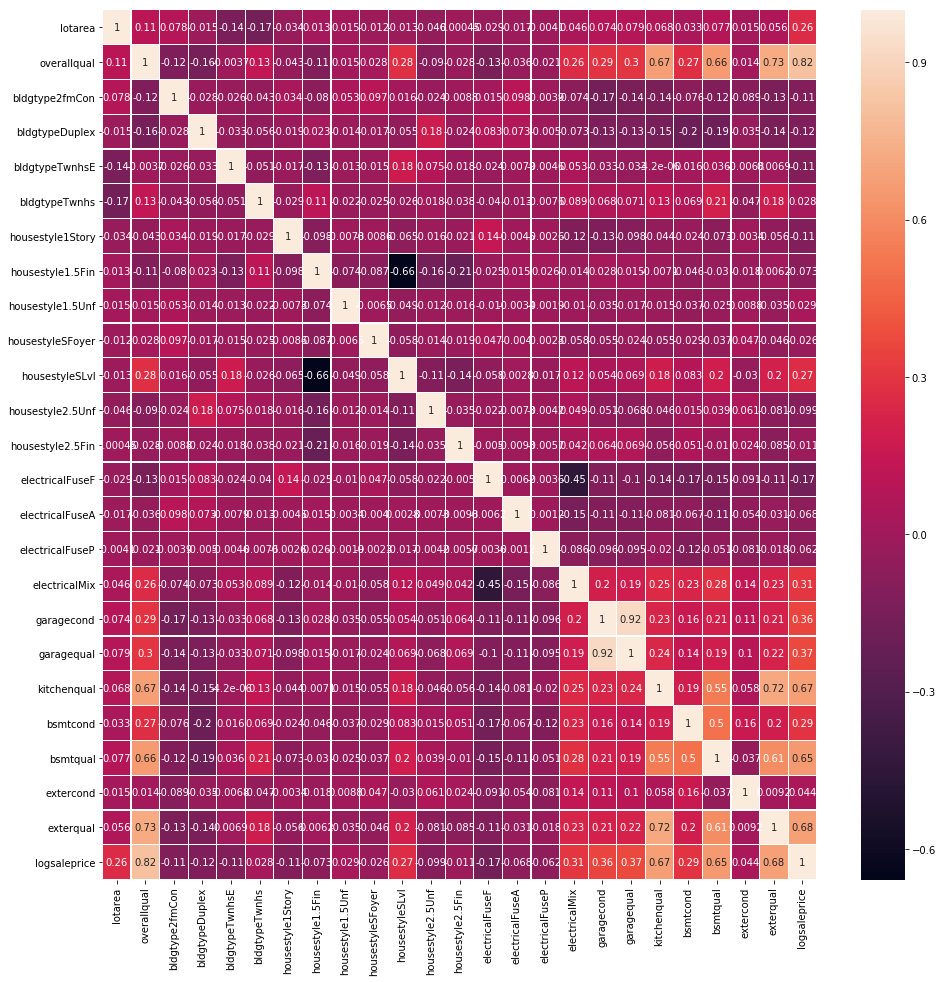

In [18]:
# 4. Low multicollinearity
plt.figure(figsize=(16,16))
sns.heatmap(feature_df.corr(), linewidth=0.2, annot=True)
# Lots of issues here with so many variables. overallqual especially is correlated very strongly with
# a bunch of other features, but it's also the most correlated with price. Not sure how to fix this.
# PCA is not good for this kind of machine learning as well because the features are important.

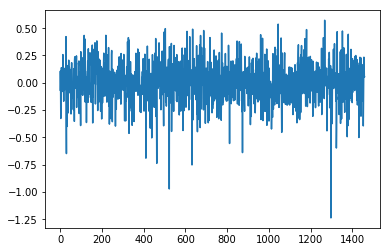

In [19]:
# 5. Error terms should be uncorrelated with one another
plt.plot(errors)
plt.show()
# I think this looks mostly good?

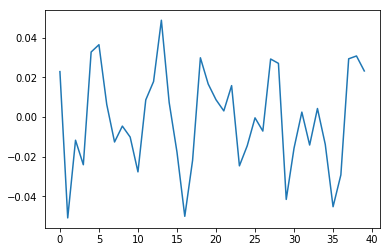

In [20]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()
# Yes, this is very low!

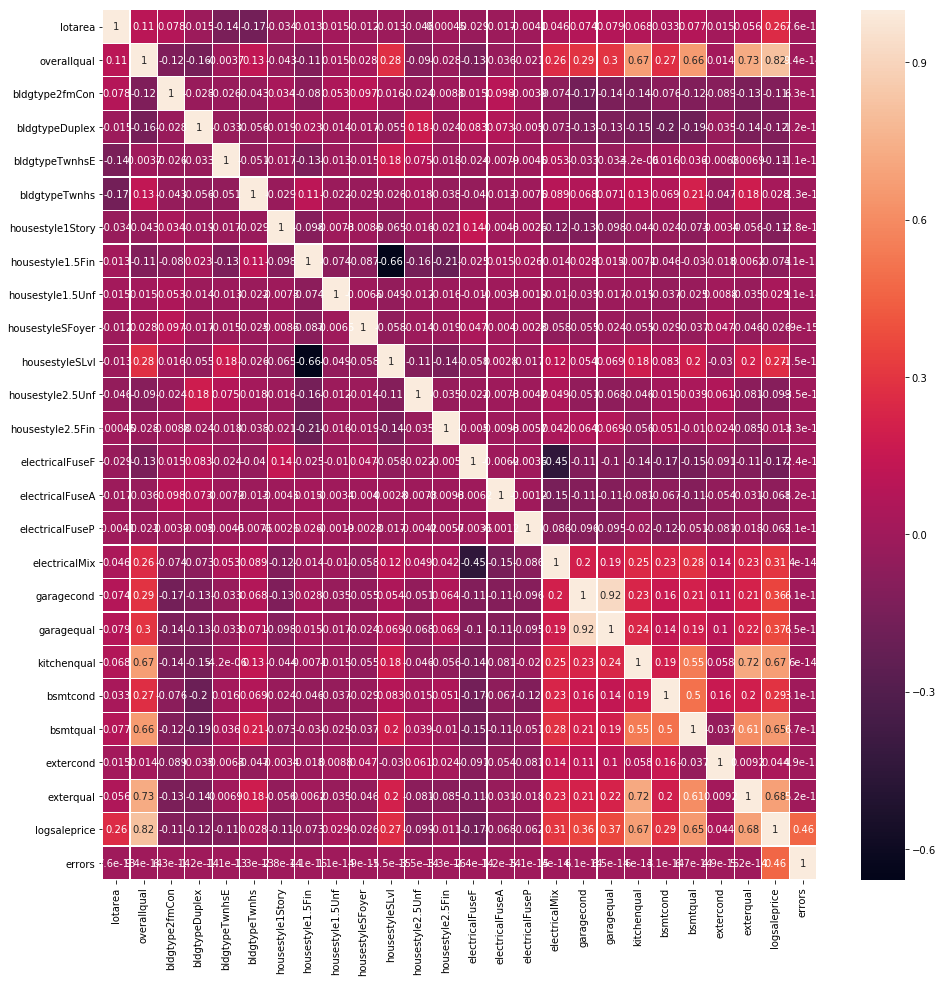

In [21]:
feature_df['errors'] = errors
plt.figure(figsize=(16,16))
sns.heatmap(feature_df.corr(), linewidth=0.2, annot=True)
# All of the correlations are extremely close to 0.